# **Milestone 2 - Fingerprint Processing**

This section contains tasks that will help you get familiar with the basics of fingerprint processing.

You may add more code and markdown cells as needed

## TASK 1
* Load the Fingerprint Image `datasets\task3\1.tiff`
* Display it using `plt.imshow()`
* Load the Fingerprint Image `datasets\task3\2.tiff`
* Display it using `plt.imshow()`

#### Load the Fingerprint Image `datasets\task3\1.tiff`

In [6]:
## Hint: use opencv
import cv2
## Hint: use opencv
import cv2
import seaborn

# Load the fingerprint image
image = cv2.imread('1.tiff', 0)

#### Display the Fingerprint image

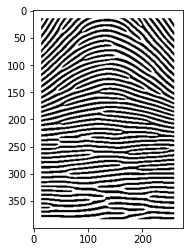

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [8]:
## Hint: use matplotlib
## Hint: use matplotlib
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np


image_tiff = Image.open('./datasets/task3/1.tiff')
plt.imshow(image_tiff, cmap='gray')
plt.show()


imarray = np.array(image_tiff)
imarray


#### Load the Fingerprint Image `datasets\task3\2.tiff`

In [9]:
## Hint: use opencv


# Load the fingerprint image
image = cv2.imread('2.tiff', 0)

#### Display the Second Fingerprint image

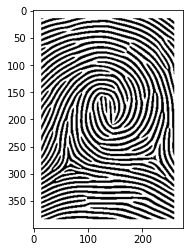

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [10]:
## Hint: use matplotlib
from PIL import Image
import numpy as np


image_tiff = Image.open('./datasets/task3/2.tiff')
plt.imshow(image_tiff, cmap='gray')
plt.show()


imarray = np.array(image_tiff)
imarray

## TASK 2
* Extract the minutia points from the fingerprint images
* Display the minutia vectors

Hint: Each minutiae vector will have the following format: 
> `[x, y, theta, type]` where `type` is `0` for ridge ending and `1` for ridge bifurcation

#### Extract the minutia vectors from the fingerprint images of `TASK 1` as a list of vectors

In [20]:
import cv2
import numpy as np
import skimage.morphology
import matplotlib
import matplotlib.pyplot as plt
from skimage.morphology import convex_hull_image, erosion
from skimage.morphology import square
import math
import glob
from PIL import Image
from PIL import ImageEnhance

class MinutiaeFeature(object):
    def __init__(self, locX, locY, Orientation, Type):
        self.locX = locX;
        self.locY = locY;
        self.Orientation = Orientation;
        self.Type = Type;
    def __repr__(self):
        return f' locX:{self.locX} locY:{self.locY}  Orientation:{self.Orientation} Type:{self.Type}'

class FingerprintFeatureExtractor(object):
    def __init__(self):
        self._mask = []
        self._skel = []
        self.minutiaeTerm = []
        self.minutiaeBif = []

    def __skeletonize(self, img):
        img = np.uint8(img > 128)
        self._skel = skimage.morphology.skeletonize(img)
        self._skel = np.uint8(self._skel) * 255
        self._mask = img * 255

    def __computeAngle(self, block, minutiaeType):
        angle = []
        (blkRows, blkCols) = np.shape(block);
        CenterX, CenterY = (blkRows - 1) / 2, (blkCols - 1) / 2
        if (minutiaeType.lower() == 'termination'):
            sumVal = 0;
            for i in range(blkRows):
                for j in range(blkCols):
                    if ((i == 0 or i == blkRows - 1 or j == 0 or j == blkCols - 1) and block[i][j] != 0):
                        angle.append(-math.degrees(math.atan2(i - CenterY, j - CenterX)))
                        sumVal += 1
                        if (sumVal > 1):
                            angle.append(float('nan'))
            return (angle)

        elif (minutiaeType.lower() == 'bifurcation'):
            (blkRows, blkCols) = np.shape(block);
            CenterX, CenterY = (blkRows - 1) / 2, (blkCols - 1) / 2
            angle = []
            sumVal = 0;
            for i in range(blkRows):
                for j in range(blkCols):
                    if ((i == 0 or i == blkRows - 1 or j == 0 or j == blkCols - 1) and block[i][j] != 0):
                        angle.append(-math.degrees(math.atan2(i - CenterY, j - CenterX)))
                        sumVal += 1
            if (sumVal != 3):
                angle.append(float('nan'))
            return (angle)

    def __getTerminationBifurcation(self):
        self._skel = self._skel == 255;
        (rows, cols) = self._skel.shape;
        self.minutiaeTerm = np.zeros(self._skel.shape);
        self.minutiaeBif = np.zeros(self._skel.shape);

        for i in range(1, rows - 1):
            for j in range(1, cols - 1):
                if (self._skel[i][j] == 1):
                    block = self._skel[i - 1:i + 2, j - 1:j + 2];
                    block_val = np.sum(block);
                    if (block_val == 2):
                        self.minutiaeTerm[i, j] = 1;
                    elif (block_val == 4):
                        self.minutiaeBif[i, j] = 1;

        self._mask = convex_hull_image(self._mask > 0)
        self._mask = erosion(self._mask, square(5))  # Structuing element for mask erosion = square(5)
        self.minutiaeTerm = np.uint8(self._mask) * self.minutiaeTerm

    def __removeSpuriousMinutiae(self, minutiaeList, img, thresh):#see in sp.text file for more detaile
        img = img * 0;
        SpuriousMin = [];
        numPoints = len(minutiaeList);
        D = np.zeros((numPoints, numPoints))
        for i in range(1,numPoints):
            for j in range(0, i):
                (X1,Y1) = minutiaeList[i]['centroid']
                (X2,Y2) = minutiaeList[j]['centroid']

                dist = np.sqrt((X2-X1)**2 + (Y2-Y1)**2);
                D[i][j] = dist
                if(dist < thresh):
                    SpuriousMin.append(i)
                    SpuriousMin.append(j)

        SpuriousMin = np.unique(SpuriousMin)
        for i in range(0,numPoints):
            if(not i in SpuriousMin):
                (X,Y) = np.int16(minutiaeList[i]['centroid']);
                img[X,Y] = 1;

        img = np.uint8(img);
        return(img)

    def __cleanMinutiae(self, img):
        self.minutiaeTerm = skimage.measure.label(self.minutiaeTerm, connectivity=2);#Label connected regions of an integer array
        RP = skimage.measure.regionprops(self.minutiaeTerm)#Measure properties of labeled image regions.
        self.minutiaeTerm = self.__removeSpuriousMinutiae(RP, np.uint8(img), 10);

    def __performFeatureExtraction(self):
        FeaturesTerm = []
        self.minutiaeTerm = skimage.measure.label(self.minutiaeTerm, connectivity=2);
        RP = skimage.measure.regionprops(np.uint8(self.minutiaeTerm))

        WindowSize = 2  # --> For Termination, the block size must can be 3x3, or 5x5. Hence the window selected is 1 or 2
        FeaturesTerm = []
        for num, i in enumerate(RP):
            (row, col) = np.int16(np.round(i['Centroid']))
            block = self._skel[row - WindowSize:row + WindowSize + 1, col - WindowSize:col + WindowSize + 1]
            angle = self.__computeAngle(block, 'Termination')
            if(len(angle) == 1):
                FeaturesTerm.append(MinutiaeFeature(row, col, angle, 0))

        FeaturesBif = []
        self.minutiaeBif = skimage.measure.label(self.minutiaeBif, connectivity=2);
        RP = skimage.measure.regionprops(np.uint8(self.minutiaeBif))
        WindowSize = 1  # --> For Bifurcation, the block size must be 3x3. Hence the window selected is 1
        for i in RP:
            (row, col) = np.int16(np.round(i['Centroid']))
            block = self._skel[row - WindowSize:row + WindowSize + 1, col - WindowSize:col + WindowSize + 1]
            angle = self.__computeAngle(block, 'Bifurcation')
            if(len(angle) == 3):
                FeaturesBif.append(MinutiaeFeature(row, col, angle, 1))
        return (FeaturesTerm, FeaturesBif)

    def extractMinutiaeFeatures(self, img):
        self.__skeletonize(img)

        self.__getTerminationBifurcation()

        self.__cleanMinutiae(img)

        FeaturesTerm, FeaturesBif = self.__performFeatureExtraction()
        return(FeaturesTerm, FeaturesBif)

    def showResults(self):
        BifLabel = skimage.measure.label(self.minutiaeBif, connectivity=2);
        TermLabel = skimage.measure.label(self.minutiaeTerm, connectivity=2);

        minutiaeBif = TermLabel * 0;
        minutiaeTerm = BifLabel * 0;

        (rows, cols) = self._skel.shape
        DispImg = np.zeros((rows, cols, 3), np.uint8)
        DispImg[:, :, 0] = 255*self._skel;
        DispImg[:, :, 1] = 255*self._skel;
        DispImg[:, :, 2] = 255*self._skel;

        RP = skimage.measure.regionprops(BifLabel)
        for idx, i in enumerate(RP):
            (row, col) = np.int16(np.round(i['Centroid']))
            minutiaeBif[row, col] = 1;
            (rr, cc) = skimage.draw.rectangle_perimeter((row - 2, col - 2),  end=(row + 2, col + 2))
            skimage.draw.set_color(DispImg, (rr, cc), (0, 0, 255));

        RP = skimage.measure.regionprops(TermLabel)
        for idx, i in enumerate(RP):
            (row, col) = np.int16(np.round(i['Centroid']))
            minutiaeTerm[row, col] = 1;
            (rr, cc) = skimage.draw.circle_perimeter(row, col, 3);
            skimage.draw.set_color(DispImg, (rr, cc), (255, 0, 0));

        return DispImg


def extract_minutiae_features(img, showResult=False):
    feature_extractor = FingerprintFeatureExtractor()
    FeaturesTerm, FeaturesBif = feature_extractor.extractMinutiaeFeatures(img)

    if(showResult):
        image=feature_extractor.showResults()

    return(FeaturesTerm, FeaturesBif,image)







#### Display the minutia vectors

In [21]:
## Hint: Each minutiae vector will have the following format: 
## [x, y, theta, type] where type is 0 for ridge ending and 1 for ridge bifurcation


img = cv2.imread('./datasets/task3/1.tiff', 0)	
def get_minutiae_and_matching(img,showResult=False):
      FeaturesTerminations, FeaturesBifurcations,DispImg = extract_minutiae_features(img, showResult=True)
      
      print()
      print("--------------------Terminations Points-----------------------------")
      print()
      print([FeaturesTerminations])
      print()
      print("--------------------Bifurcations Points-----------------------------")
      print()
      print([FeaturesBifurcations])
      print("No of Bifurcations found in this image : ")
      print(len(FeaturesBifurcations))
      print("No of Ridge endings found in this image : ")
      print(len(FeaturesTerminations))
      print("Total in this image : ")
      print(len(FeaturesBifurcations)+len(FeaturesTerminations))
get_minutiae_and_matching(img,showResult=True)




--------------------Terminations Points-----------------------------

[[ locX:27 locY:198  Orientation:[135.0] Type:0,  locX:37 locY:91  Orientation:[26.56505117707799] Type:0,  locX:88 locY:95  Orientation:[26.56505117707799] Type:0,  locX:149 locY:124  Orientation:[-0.0] Type:0,  locX:173 locY:57  Orientation:[26.56505117707799] Type:0,  locX:206 locY:50  Orientation:[-0.0] Type:0,  locX:206 locY:212  Orientation:[153.434948822922] Type:0,  locX:223 locY:162  Orientation:[-180.0] Type:0,  locX:229 locY:228  Orientation:[-180.0] Type:0,  locX:261 locY:176  Orientation:[-0.0] Type:0,  locX:289 locY:193  Orientation:[-0.0] Type:0]]

--------------------Bifurcations Points-----------------------------

[[ locX:7 locY:21  Orientation:[-180.0, -0.0, -90.0] Type:1,  locX:7 locY:31  Orientation:[-180.0, -0.0, -90.0] Type:1,  locX:7 locY:42  Orientation:[-180.0, -0.0, -90.0] Type:1,  locX:7 locY:52  Orientation:[-180.0, -0.0, -90.0] Type:1,  locX:7 locY:64  Orientation:[-180.0, -0.0, -90.0] 

## TASK 3
* Display the minutia vectors on the fingerprint images

#### Display the minutia vectors from `TASK 2` on the fingerprint images of `TASK 1`

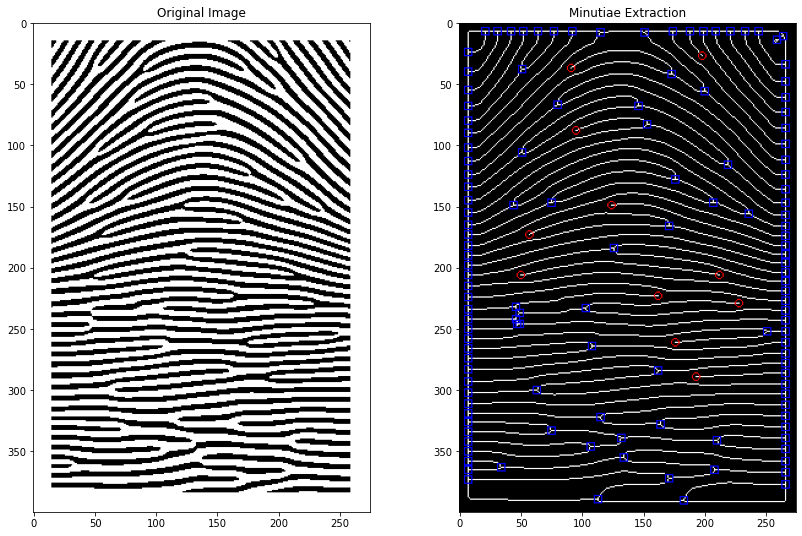

In [22]:
## Hint: use matplotlib and stacked images to show the results
## Use red circle for ridge ending and blue square for ridge bifurcation

img = cv2.imread('./datasets/task3/1.tiff', 0)	
def get_minutiae_and_matching(img,showResult=False):
      FeaturesTerminations, FeaturesBifurcations,DispImg = extract_minutiae_features(img, showResult=True)
      font = cv2.FONT_HERSHEY_SIMPLEX
      color = (255, 0, 0)
      org = (10, 15)
      #DispImg = cv2.putText(DispImg, 'Bifurcations', org, font,0.5, color,2, cv2.LINE_AA)
      color1 = (0, 0, 255)
      org1 = (10, 30)
      #DispImg = cv2.putText(DispImg, 'Terminations', org1, font,0.5, color1,2, cv2.LINE_AA)

# Set plot size
      fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 9))

      axs[0].imshow(img, cmap='gray')
      axs[0].set_title('Original Image')

      axs[1].imshow(DispImg, cmap='gray')
      axs[1].set_title('Minutiae Extraction')
      

      
      plt.show()
      cv2.imshow('Minutiae Points', DispImg)

      
get_minutiae_and_matching(img,showResult=True)



Note : As I can see the bifurcations are too many because of the sides, but this algorithm is the most sound I have got on internet till now,
I have made necessary changes to meet the code requirements as mentioned, But I think the extra can be removed from it, I am trying to understand
and change this code a bit so that the boundary minutaie points gets away not all just redundant.


The code source- https://github.com/YogeshMoun/Minutiae-Extraction-and-Matching